In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

2.0.0


In [3]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [4]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 3us/step


'/home/kitamura/.keras/datasets/auto-mpg.data'

In [32]:
column_names = ['MPG', 'Cylinders', 'Displacement' , 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                          na_values="?", comment='\t',
                          sep=" ", skipinitialspace=True)
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [33]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [34]:
dataset = dataset.dropna()

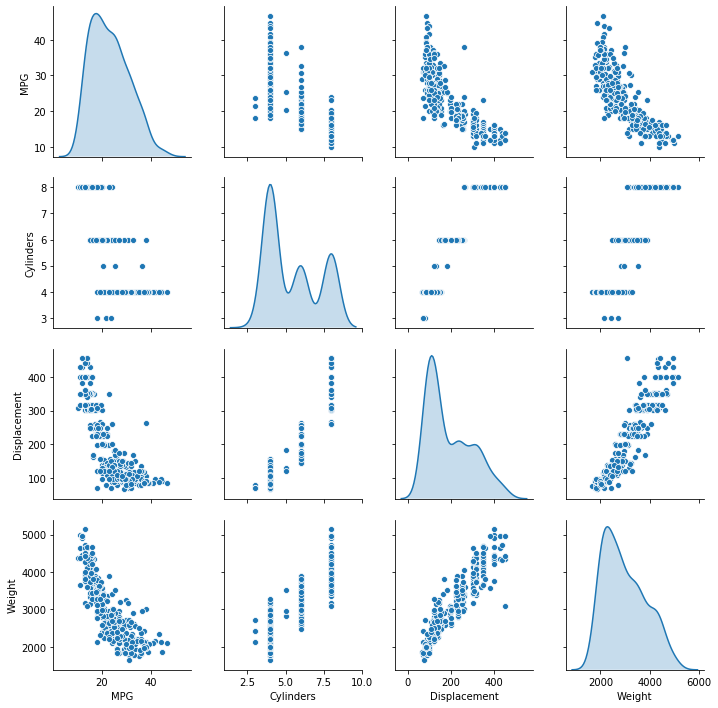

In [35]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [36]:
train_stats = train_dataset.describe()
train_stats.pop('MPG')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Origin,314.0,1.573248,0.800988,1.0,1.00,1.0,2.00,3.0


In [37]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [38]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [39]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
    return model

In [40]:
model = build_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                512       
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [41]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.18491791],
       [-0.09785493],
       [-0.04574161],
       [-0.23186943],
       [ 0.06130949],
       [-0.07076801],
       [ 0.08209179],
       [-0.06558306],
       [-0.01534683],
       [ 0.42037034]], dtype=float32)

In [44]:
EPOCHS = 1000
history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split=0.2, verbose=0,
    callbacks=[tfdocs.modeling.EpochDots()]
)


Epoch: 0, loss:568.7790,  mae:22.6202,  mse:568.7790,  val_loss:562.1176,  val_mae:22.4652,  val_mse:562.1176,  
....................................................................................................
Epoch: 100, loss:6.3595,  mae:1.7684,  mse:6.3595,  val_loss:9.2504,  val_mae:2.2733,  val_mse:9.2504,  
....................................................................................................
Epoch: 200, loss:5.5217,  mae:1.6340,  mse:5.5217,  val_loss:9.0143,  val_mae:2.3111,  val_mse:9.0143,  
....................................................................................................
Epoch: 300, loss:4.8934,  mae:1.5119,  mse:4.8934,  val_loss:9.0854,  val_mae:2.1983,  val_mse:9.0854,  
....................................................................................................
Epoch: 400, loss:4.4131,  mae:1.4368,  mse:4.4131,  val_loss:8.9287,  val_mae:2.2028,  val_mse:8.9287,  
..............................................................

In [45]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.570218,1.038087,2.570218,9.366632,2.236098,9.366632,995
996,2.444083,0.995768,2.444083,9.532373,2.200080,9.532372,996
997,2.572184,1.055741,2.572184,10.402024,2.378065,10.402024,997
998,2.713127,1.067967,2.713128,9.607483,2.275799,9.607484,998
999,2.591088,1.059023,2.591088,9.323897,2.198055,9.323897,999


Text(0, 0.5, 'MAE [MPG]')

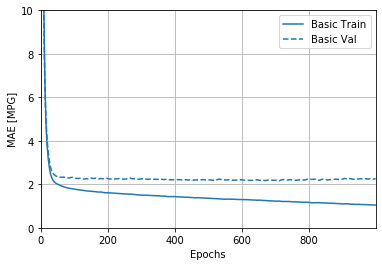

In [47]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric="mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

Text(0, 0.5, 'MSE [MPG^2]')

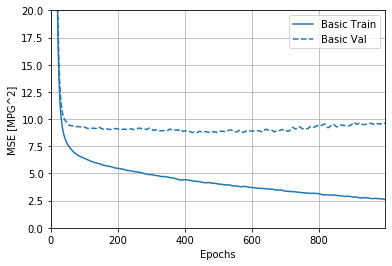

In [48]:
plotter.plot({'Basic': history}, metric="mse")
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')

In [50]:
model = build_model()
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
early_history = model.fit(normed_train_data, train_labels, 
                         epochs=EPOCHS, validation_split=0.2, verbose=0,
                         callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:524.8349,  mae:21.7329,  mse:524.8348,  val_loss:506.0497,  val_mae:21.3156,  val_mse:506.0497,  
.........................................................................

Text(0, 0.5, 'MAE [MPG]')

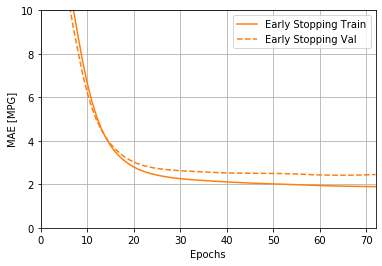

In [51]:
plotter.plot({'Early Stopping': early_history}, metric='mae')
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

In [53]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print("Testing set Mean Abs Error : {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 6.8674 - mae: 1.9291 - mse: 6.8674
Testing set Mean Abs Error :  1.93 MPG


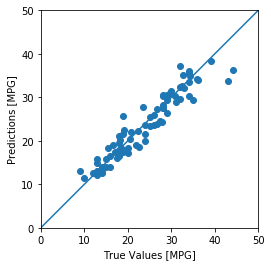

In [54]:
test_predictions = model.predict(normed_test_data).flatten()
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims)

Text(0, 0.5, 'Count')

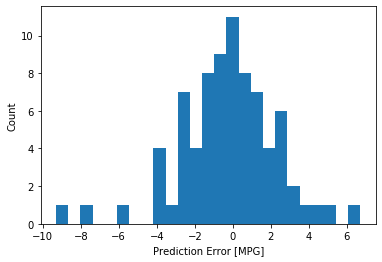

In [55]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
plt.ylabel('Count')